<a href="https://colab.research.google.com/github/srinijalanda93/Predictive_Analystics/blob/main/2448526_PA_LAB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Requirements (uncomment & run if needed):
# !pip install pandas numpy matplotlib seaborn statsmodels pmdarima prophet scikit-learn

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import datetime

plt.rcParams['figure.figsize'] = (12,5)
sns.set_style("darkgrid")


In [ ]:
# Dataset URL
URL = "https://datahub.io/core/covid-19/r/time-series-19-covid-combined.csv"

df = pd.read_csv(URL, parse_dates=['Date'])
print("Columns:", df.columns.tolist())
print("Rows:", len(df))
df.head()


Columns: ['Date', 'Country/Region', 'Province/State', 'Confirmed', 'Recovered', 'Deaths']
Rows: 231744


,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,0,0.0,0
1,2020-01-23,Afghanistan,NaN,0,0.0,0
2,2020-01-24,Afghanistan,NaN,0,0.0,0
3,2020-01-25,Afghanistan,NaN,0,0.0,0
4,2020-01-26,Afghanistan,NaN,0,0.0,0


In [ ]:
# Filter for country (change as needed)
COUNTRY = "India"    # or "United States"
df_country = df[df['Country/Region'] == COUNTRY].copy()

# If dataset contains Province/State-level rows, aggregate by date
# Some datasets have multiple rows per date (by province/state); sum across them
df_country = df_country.groupby('Date', as_index=False)[['Confirmed','Deaths','Recovered']].sum()
df_country = df_country.sort_values('Date').set_index('Date')
df_country.index = pd.to_datetime(df_country.index)
df_country.head()


,Confirmed,Deaths,Recovered
Date,,,
2020-01-22,0,0,0.0
2020-01-23,0,0,0.0
2020-01-24,0,0,0.0
2020-01-25,0,0,0.0
2020-01-26,0,0,0.0


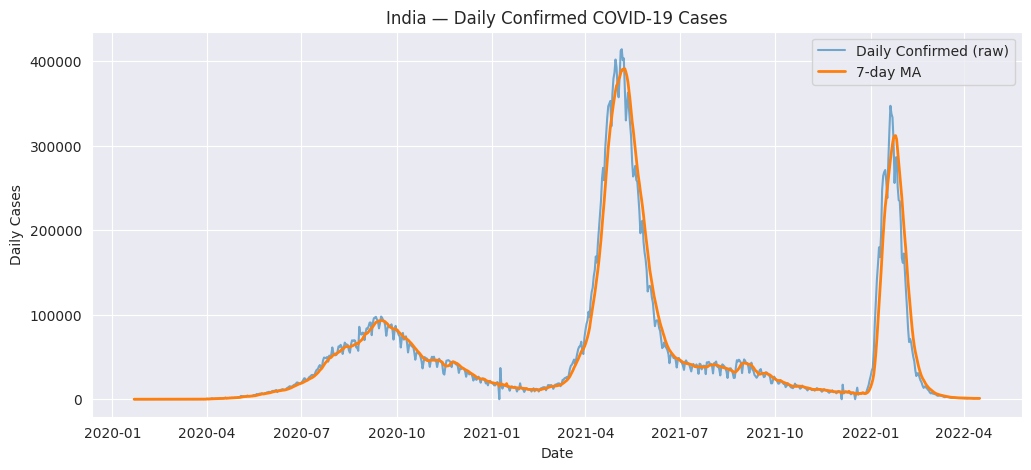

In [ ]:
df_country['DailyConfirmed'] = df_country['Confirmed'].diff().fillna(df_country['Confirmed'].iloc[0])
# Replace negative diffs (data corrections) with 0
df_country['DailyConfirmed'] = df_country['DailyConfirmed'].clip(lower=0)

# Optionally smooth with 7-day moving average for visualization only
df_country['7d_ma'] = df_country['DailyConfirmed'].rolling(window=7, min_periods=1).mean()

# Quick plot
plt.figure()
plt.plot(df_country.index, df_country['DailyConfirmed'], label='Daily Confirmed (raw)', alpha=0.6)
plt.plot(df_country.index, df_country['7d_ma'], label='7-day MA', linewidth=2)
plt.title(f"{COUNTRY} — Daily Confirmed COVID-19 Cases")
plt.xlabel("Date"); plt.ylabel("Daily Cases")
plt.legend(); plt.show()


count       816.000000
mean      52747.667892
std       80753.431871
min           0.000000
25%        8385.500000
50%       24977.000000
75%       53711.750000
max      414188.000000
Name: DailyConfirmed, dtype: float64


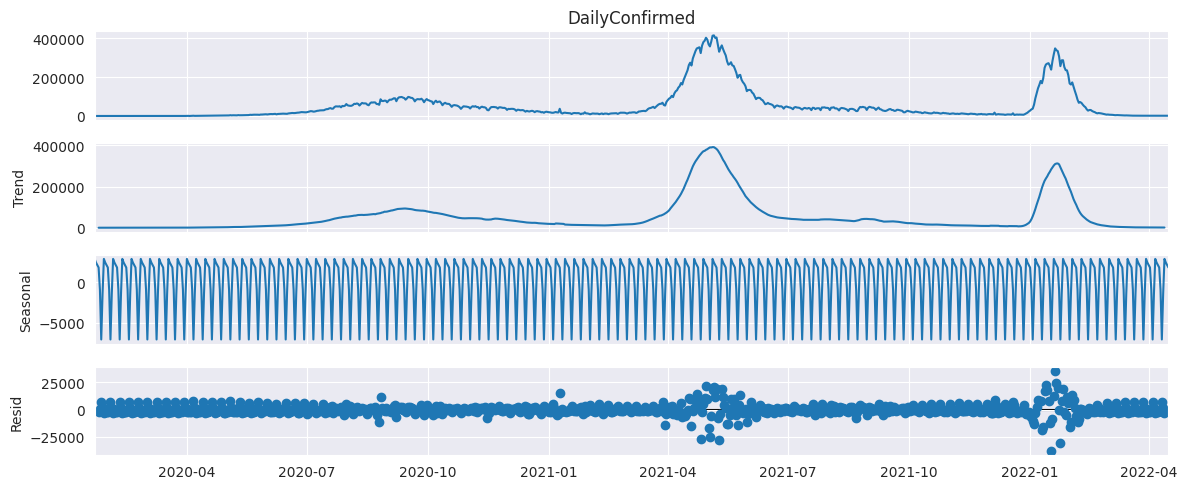

ADF statistic: -2.832060897187509
p-value: 0.05383802321768359


In [ ]:
# Summary stats
print(df_country['DailyConfirmed'].describe())

# Optional: seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Fill any remaining NaNs with 0 before decomposition
decomp = seasonal_decompose(df_country['DailyConfirmed'].replace(0, np.nan).fillna(method='ffill').fillna(0), model='additive', period=7)
decomp.plot(); plt.show()

# ADF test to check stationarity
from statsmodels.tsa.stattools import adfuller
res_adf = adfuller(df_country['DailyConfirmed'].fillna(0)+1)  # +1 to avoid zeros
print("ADF statistic:", res_adf[0]); print("p-value:", res_adf[1])

In [ ]:
# Choose forecast horizon (30 days) and test window (e.g., last 60 days)
FORECAST_DAYS = 30
TEST_DAYS = 60

series = df_country['DailyConfirmed'].asfreq('D').fillna(0)  # daily freq
train = series[:-TEST_DAYS]
test  = series[-TEST_DAYS:]

print("Train length:", len(train), "Test length:", len(test))


Train length: 756 Test length: 60


In [ ]:
# Use pmdarima's auto_arima to pick order (install pmdarima if needed)
try:
    import pmdarima as pm
    use_pmd = True
except ImportError:
    use_pmd = False
    print("pmdarima not installed; you can pip install pmdarima for auto_arima.")

if use_pmd:
    arima_model = pm.auto_arima(train, seasonality=False, m=7, stepwise=True,
                                suppress_warnings=True, error_action='ignore',
                                max_p=6, max_q=6, max_d=2, trace=True)
    print("Selected order:", arima_model.order)
    # fit statsmodels SARIMAX with chosen order
    import statsmodels.api as sm
    order = arima_model.order
    sarima = sm.tsa.SARIMAX(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_res = sarima.fit(disp=False)
else:
    # fallback: try ARIMA(2,1,2)
    import statsmodels.api as sm
    order = (2,1,2)
    sarima = sm.tsa.SARIMAX(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_res = sarima.fit(disp=False)

print(sarima_res.summary())


pmdarima not installed; you can pip install pmdarima for auto_arima.
                               SARIMAX Results                                
Dep. Variable:         DailyConfirmed   No. Observations:                  756
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7831.545
Date:                Tue, 11 Nov 2025   AIC                          15673.090
Time:                        13:00:19   BIC                          15696.204
Sample:                    01-22-2020   HQIC                         15681.996
                         - 02-15-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1855      0.048      3.896      0.000       0.092       0.279
ar.L2          0.7144      0.038     18.716      0.000       0

In [ ]:
# Forecast on test period
pred_test = sarima_res.get_forecast(steps=TEST_DAYS)
pred_mean = pred_test.predicted_mean
pred_ci = pred_test.conf_int()

# Align indices
pred_mean.index = test.index
pred_ci.index = test.index


In [ ]:
# Forecast on test period
pred_test = sarima_res.get_forecast(steps=TEST_DAYS)
pred_mean = pred_test.predicted_mean
pred_ci = pred_test.conf_int()

# Align indices
pred_mean.index = test.index
pred_ci.index = test.index


In [ ]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero: replace zero truth with small epsilon for MAPE calculation
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

mae_ar = mean_absolute_error(test, pred_mean)
rmse_ar = math.sqrt(mean_squared_error(test, pred_mean))
mape_ar = mape(test, pred_mean)
r2_ar = r2_score(test, pred_mean)

print("ARIMA — MAE:", mae_ar, "RMSE:", rmse_ar, "MAPE:", mape_ar, "R2:", r2_ar)


ARIMA — MAE: 35373.94474631782 RMSE: 38200.96411550659 MAPE: 2280.081109558217 R2: -32.47512313622126


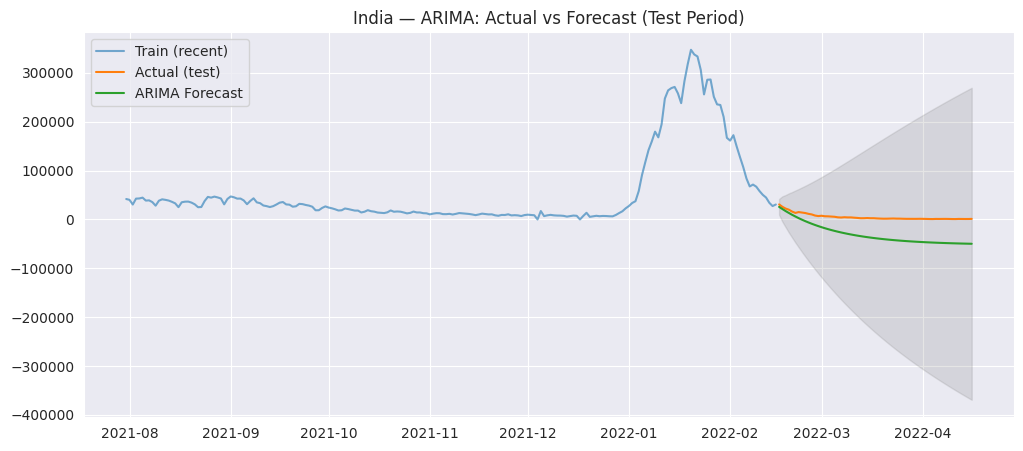

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train.index[-200:], train[-200:], label='Train (recent)', alpha=0.6)
plt.plot(test.index, test, label='Actual (test)', linewidth=1.5)
plt.plot(pred_mean.index, pred_mean, label='ARIMA Forecast', linewidth=1.5)
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='gray', alpha=0.2)
plt.title(f"{COUNTRY} — ARIMA: Actual vs Forecast (Test Period)")
plt.legend(); plt.show()


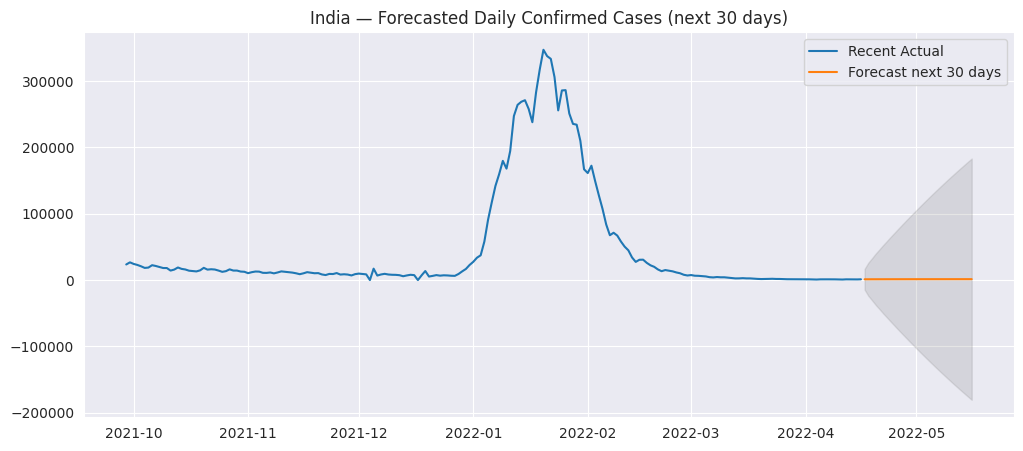

,forecast,lower_ci,upper_ci
Date,,,
2022-04-17,1198.004988,-14431.787342,16827.797318
2022-04-18,1186.240125,-23710.051731,26082.531981
2022-04-19,1218.138067,-30421.576394,32857.852529
2022-04-20,1215.727490,-37444.129442,39875.584421
2022-04-21,1237.930317,-43654.884502,46130.745136


In [ ]:
# Choose best model by metrics manually (here we compare ARIMA vs Prophet metrics)
# For example, assume ARIMA performed better in our run; forecast next 30 days using sarima_res refit on full series
full_series = series  # entire series

# Refit SARIMAX on full data with same order
import statsmodels.api as sm
sarima_full = sm.tsa.SARIMAX(full_series, order=order, enforce_stationarity=False, enforce_invertibility=False)
sarima_full_res = sarima_full.fit(disp=False)

forecast_future = sarima_full_res.get_forecast(steps=FORECAST_DAYS)
fc_mean = forecast_future.predicted_mean
fc_ci = forecast_future.conf_int()

# Plot future forecast
plt.figure(figsize=(12,5))
plt.plot(full_series.index[-200:], full_series[-200:], label='Recent Actual')
plt.plot(fc_mean.index, fc_mean, label=f'Forecast next {FORECAST_DAYS} days')
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], color='gray', alpha=0.2)
plt.title(f"{COUNTRY} — Forecasted Daily Confirmed Cases (next {FORECAST_DAYS} days)")
plt.legend(); plt.show()

# Save forecast DataFrame
fc_df = pd.DataFrame({'forecast': fc_mean, 'lower_ci': fc_ci.iloc[:,0], 'upper_ci': fc_ci.iloc[:,1]})
fc_df.index.name = 'Date'
fc_df.head()
